In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/home/beans/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import *
from loaders import *
from constants import *
from imports import *
from train_utils import get_torque
from models import EffNet
from input_prep import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
%%time
bs = 32
dataloader = TrnLoader(bs)

CPU times: user 6min 13s, sys: 3min 21s, total: 9min 34s
Wall time: 41.1 s


In [3]:
m = EffNet().to(device) 
model_stem = "12.30_e6"
m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m_{model_stem}.torch"), strict=False)
#m.set_for_viz() # comment out hooks in model to test this path
m.eval()
sum([torch.numel(p) for p in m.parameters()]) / 1000

18303.055

In [4]:
# m.load_trt_backbone() # for trt, change bs to one, make inputs full float

In [5]:
"""bs = 1
dataloader = RunLoader('/home/beans/blender_membank/dataloader_05/run_10', is_rw=False)
dataloader.queue_up_batch()"""

"bs = 1\ndataloader = RunLoader('/home/beans/blender_membank/dataloader_05/run_10', is_rw=False)\ndataloader.queue_up_batch()"

In [6]:
imgs_all, wp_angles_all, aux_model_all, angle_preds_all, aux_targets_all = [], [], [], [], []
aux_pred_all = []
total_loss = 0
n_updates = 60

with torch.no_grad():
    for i in range(n_updates):
        batch = dataloader.get_batch()
        if batch is None: break # happens w RunLoader
        (img, aux_model, aux_calib), targets, (to_pred_mask, is_first_in_seq) = batch
        wp_angles, wp_headings, wp_curvatures, wp_rolls, wp_zs, aux_targets = targets

        if is_first_in_seq: 
            print("first in seq")
            m.reset_hidden(bs) # reset hiddens to zeros

        with torch.cuda.amp.autocast(): 
            wps_pred, aux_pred, obs_net_out = m(img, aux_model, aux_calib)
            #wps_pred, aux_pred, obs_net_out = m(img.float(), aux_model.float(), aux_calib.float()) # trt
            
            wp_angles_pred, wp_headings_pred, wp_curvatures_pred, wp_rolls_pred, wp_zs_pred = torch.chunk(wps_pred, 5, -1)
            
        img = (denorm_img(img) * 255).permute(0,1,3,4,2).cpu().numpy().astype('uint8')  
        wp_angles = (wp_angles.cpu() * TARGET_NORM).numpy()
        wp_angles_pred = (wp_angles_pred.cpu() * TARGET_NORM).numpy()    
        
        total_loss += mse(wp_angles, wp_angles_pred)
        
        imgs_all.append(img)
        wp_angles_all.append(wp_angles)
        angle_preds_all.append(wp_angles_pred)
        
        aux_model = (aux_model.cpu()*model_in_aux_norm_constants).cpu().numpy()
        aux_model_all.append(aux_model)
        
        aux_targets = aux_targets.cpu().numpy() * AUX_TARGET_NORM
        aux_targets_all.append(aux_targets)
        
        aux_pred = aux_pred.detach().cpu().numpy() * AUX_TARGET_NORM
        aux_pred_all.append(aux_pred)
        
imgs_all = np.concatenate(imgs_all, axis=1)
wp_angles_all = np.concatenate(wp_angles_all, axis=1)
angle_preds_all = np.concatenate(angle_preds_all, axis=1)
aux_model_all = np.concatenate(aux_model_all, axis=1)
aux_targets_all = np.concatenate(aux_targets_all, axis=1)
aux_pred_all = np.concatenate(aux_pred_all, axis=1)

total_loss /= n_updates

total_loss, imgs_all.shape, wp_angles_all.shape, angle_preds_all.shape, aux_model_all.shape

first in seq


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


(0.00052821863622133,
 (32, 60, 360, 1440, 4),
 (32, 60, 30),
 (32, 60, 30),
 (32, 60, 5))

In [7]:
_, cat_seq_len, _,_,_ = imgs_all.shape
frames = []
for b in range(bs):
    for s in range(cat_seq_len):

        _img = imgs_all[b,s,:,:,:]
        img = _img[:,:,:3]
        
        targets = wp_angles_all[b,s,:]
        preds = angle_preds_all[b,s,:]
        speed_mps = kph_to_mps(aux_model_all[b,s,2])
        aux_targets = aux_targets_all[b,s,:]
        aux_pred = aux_pred_all[b,s,:]
        
        # wps
        img = draw_wps(img, targets, color=(100, 200, 200), thickness=-1, speed_mps=speed_mps)
        img = draw_wps(img, preds, speed_mps=speed_mps)
        img = draw_aux_targets(img, aux_targets, aux_pred, sigmoid_it=True)

        img = draw_guidelines(img)
        
        img_fast = np.repeat(_img[:,:,3:4], 3, -1)
        
        img_stacked = np.concatenate([img, img_fast], axis=0)

        frames.append(img_stacked)
    
write_vid(frames, "vid_dl")
print("done")

vid_dl done!
done


In [10]:
wp_angles.shape, wp_headings.shape, wp_curvatures.shape

(torch.Size([32, 9, 30]), torch.Size([32, 9, 30]), torch.Size([32, 9, 30]))

(array([ 113.,  456., 2223., 9196., 2566., 1304.,  827.,  425.,  119.,
          51.]),
 array([-2.883 , -2.066 , -1.251 , -0.4348,  0.3813,  1.197 ,  2.014 ,
         2.83  ,  3.645 ,  4.46  ,  5.277 ], dtype=float16),
 <BarContainer object of 10 artists>)

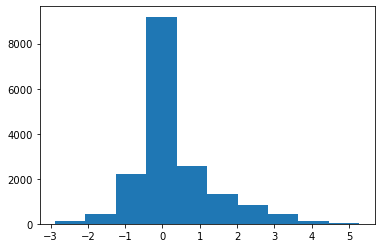

In [46]:
plt.hist((wp_angles*to_pred_mask).flatten().detach().cpu().numpy())

In [54]:
3.3*.54

1.782

(array([  16.,   90.,  505., 3027., 9853., 1779., 1425.,  435.,   85.,
          65.]),
 array([-5.066 , -3.883 , -2.697 , -1.514 , -0.3289,  0.8555,  2.04  ,
         3.225 ,  4.41  ,  5.594 ,  6.777 ], dtype=float16),
 <BarContainer object of 10 artists>)

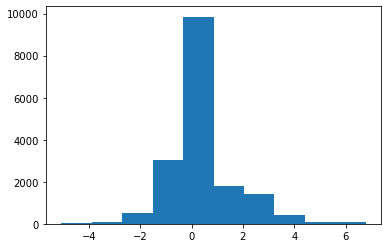

In [47]:
plt.hist((wp_headings*to_pred_mask).flatten().detach().cpu().numpy())

(array([  149.,   688.,  2620., 10216.,  1754.,  1274.,   414.,    76.,
           20.,    69.]),
 array([-0.991 , -0.687 , -0.3823, -0.078 ,  0.2263,  0.531 ,  0.835 ,
         1.14  ,  1.444 ,  1.748 ,  2.053 ], dtype=float16),
 <BarContainer object of 10 artists>)

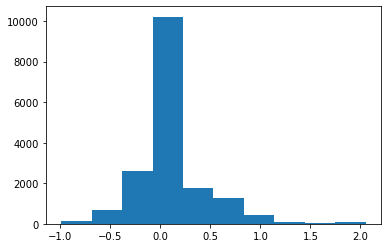

In [48]:
plt.hist((wp_curvatures*to_pred_mask).flatten().detach().cpu().numpy())

In [35]:
to_pred_mask.sum() / to_pred_mask.numel()

tensor(0.8145, device='cuda:0', dtype=torch.float16)

In [36]:
t = get_torque(wp_angles, aux)
plt.hist(t.cpu().numpy().flatten())

IndexError: index 9 is out of bounds for axis 1 with size 9

In [49]:
abs(t).max()

tensor(3904., device='cuda:0', dtype=torch.float16)

(array([161.,  60.,  19.,   8.,   4.,   2.,   1.,   0.,   0.,   1.]),
 array([  0. ,  62.6, 125.2, 187.8, 250.4, 313. , 375.5, 438.2, 500.8,
        563.5, 626. ], dtype=float16),
 <BarContainer object of 10 artists>)

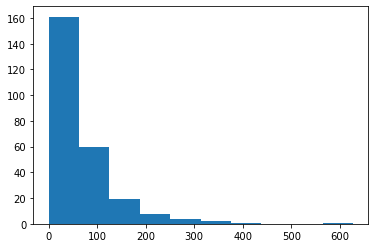

In [50]:
td = abs(t[:,1:,:] - t[:,:-1,:])
plt.hist(td.cpu().numpy().flatten())

In [51]:
abs(td).max()

tensor(626., device='cuda:0', dtype=torch.float16)

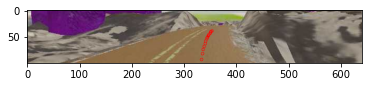

In [67]:

traj = dataloader.targets_chunk[ix][0]
img = dataloader.img_chunk[ix][0]

plt.imshow(draw_wps(img, traj))

In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)